In [12]:
%load_ext autoreload
%autoreload 2

from preprocessing import *
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


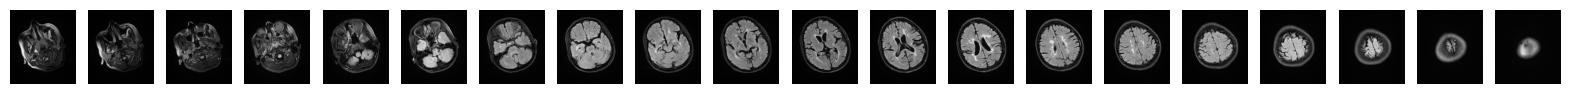

In [13]:
train_folder = "data/train"
val_folder = "data/validation"

nii_files_list_train = load_nii_files(train_folder)
nii_files_list_val = load_nii_files(val_folder)

display_all_slices(nii_files_list_train[0])

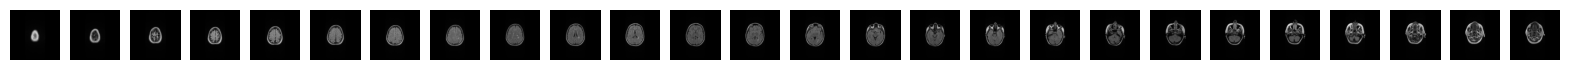

In [14]:
display_all_slices(nii_files_list_val[0])

In [15]:
all_data_train = load_all_data(nii_files_list_train)
all_data_val = load_all_data(nii_files_list_val)

In [16]:
images_train, masks_train = separate_images_masks(all_data_train)
images_val, masks_val = separate_images_masks(all_data_val)

resized_images_train = resize_all_images(images_train)
resized_masks_train = resize_all_images(masks_train)

resized_images_val = resize_all_images(images_val)
resized_masks_val = resize_all_images(masks_val)

# assert that the shapes are the same in mask and scan (x and y dimensions)
for image, mask in zip(resized_images_train, resized_masks_train):
    assert image.shape[:-1] == mask.shape[:-1]

In [17]:
# Apply the filtering function
filtered_mri_images, filtered_masks = filter_slices_with_lesions(resized_images_train, resized_masks_train)
filtered_mri_images_val, filtered_masks_val = filter_slices_with_lesions(resized_images_val, resized_masks_val)

# Output the number of slices remaining for each scan after filtering
for i, (filtered_image, filtered_mask) in enumerate(zip(filtered_mri_images, filtered_masks)):
    print(f"Scan {i + 1}: {filtered_image.shape[-1]} slices remaining, corresponding mask shape: {filtered_mask.shape}")

Scan 1: 10 slices remaining, corresponding mask shape: (256, 256, 10)
Scan 2: 12 slices remaining, corresponding mask shape: (256, 256, 12)
Scan 3: 10 slices remaining, corresponding mask shape: (256, 256, 10)
Scan 4: 16 slices remaining, corresponding mask shape: (256, 256, 16)
Scan 5: 12 slices remaining, corresponding mask shape: (256, 256, 12)
Scan 6: 7 slices remaining, corresponding mask shape: (256, 256, 7)
Scan 7: 13 slices remaining, corresponding mask shape: (256, 256, 13)
Scan 8: 13 slices remaining, corresponding mask shape: (256, 256, 13)
Scan 9: 4 slices remaining, corresponding mask shape: (256, 256, 4)
Scan 10: 13 slices remaining, corresponding mask shape: (256, 256, 13)
Scan 11: 14 slices remaining, corresponding mask shape: (256, 256, 14)
Scan 12: 7 slices remaining, corresponding mask shape: (256, 256, 7)
Scan 13: 19 slices remaining, corresponding mask shape: (256, 256, 19)
Scan 14: 13 slices remaining, corresponding mask shape: (256, 256, 13)
Scan 15: 12 slices re

In [18]:
for i, (filtered_image, filtered_mask) in enumerate(zip(filtered_mri_images_val, filtered_masks_val)):
    print(f"Scan {i + 1}: {filtered_image.shape[-1]} slices remaining, corresponding mask shape: {filtered_mask.shape}")

Scan 1: 14 slices remaining, corresponding mask shape: (256, 256, 14)
Scan 2: 16 slices remaining, corresponding mask shape: (256, 256, 16)
Scan 3: 10 slices remaining, corresponding mask shape: (256, 256, 10)
Scan 4: 12 slices remaining, corresponding mask shape: (256, 256, 12)
Scan 5: 15 slices remaining, corresponding mask shape: (256, 256, 15)
Scan 6: 14 slices remaining, corresponding mask shape: (256, 256, 14)
Scan 7: 13 slices remaining, corresponding mask shape: (256, 256, 13)
Scan 8: 13 slices remaining, corresponding mask shape: (256, 256, 13)


In [19]:
normalized_images_train = normalize_images(filtered_mri_images)
normalized_images_val = normalize_images(filtered_mri_images_val)

In [55]:
# create a data generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator


def extract_slices(image_list):
    slices = []
    for img in image_list:
        for i in range(img.shape[2]):
            slices.append(img[:,:,i])
    return np.array(slices)


datagen = ImageDataGenerator(
    rotation_range=10,  # Slight rotations to account for patient positioning
    width_shift_range=0.05,  # Small shifts to simulate patient movement
    height_shift_range=0.05,
    zoom_range=0.05,  # Slight zooming to account for scan variability
    horizontal_flip=True,  # Flips can help with generalization
    vertical_flip=False,  # Vertical flips are less common in medical imaging
    fill_mode='nearest',  # Fills in newly created pixels
    #brightness_range=[0.9, 1.1],  # Slight brightness variations
)


# Extract 2D slices from your 3D images
all_slices_train = extract_slices(normalized_images_train)
all_slices_val = extract_slices(normalized_images_val)

# Reshape to (num_slices, height, width, 1) for grayscale images
all_slices_train = all_slices_train.reshape(all_slices_train.shape + (1,))
all_slices_val = all_slices_val.reshape(all_slices_val.shape + (1,))

In [56]:
batch_size = 32
train_generator = datagen.flow(all_slices_train, batch_size=batch_size)
val_generator = datagen.flow(all_slices_val, batch_size=batch_size)

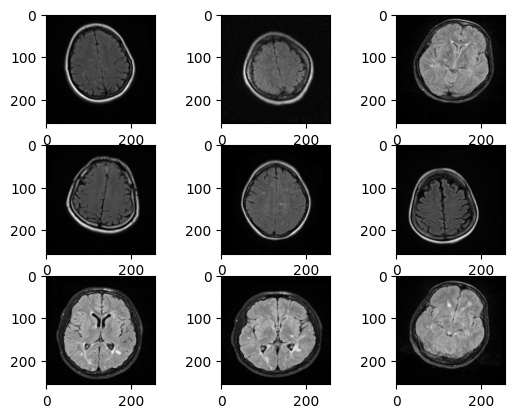

In [57]:
# display the first batch of images
import matplotlib.pyplot as plt

def show_images(images, num_images=9):
    batch = next(images)
    for i in range(num_images):
        plt.subplot(330 + 1 + i)
        plt.imshow(batch[i].reshape(256, 256), cmap=plt.get_cmap('gray'))
    plt.show()
    
show_images(train_generator)

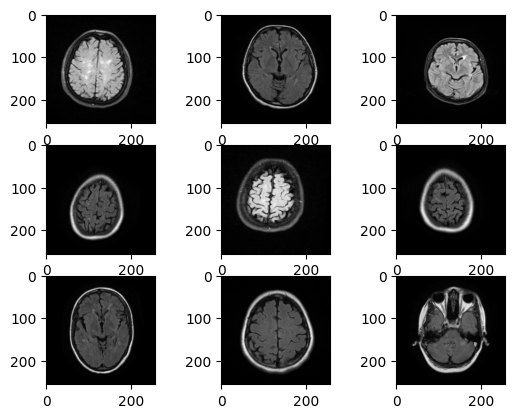

In [58]:
show_images(val_generator)